In [1]:
import numpy as np
import obspy
from hydrophone_data_processing import load, useful_variables, plotting, signal_processing
import scipy.signal as signal
import pandas as pd
import matplotlib.dates as dates
import obspy.signal.trigger as trigger
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

def import_data(day, starttime, endtime):
    daypaths = useful_variables.make_hydrophone_data_paths(borehole='a', year=2019, julian_day=day)
    starttime = obspy.UTCDateTime(starttime)
    endtime = obspy.UTCDateTime(endtime)
    data = load.import_corrected_data_for_single_day(daypaths)
    data.trim(starttime=starttime, endtime=endtime)
    return data

In [2]:
day141 = import_data(day=141, starttime='2019-05-21T07:00:00.0Z', endtime='2019-05-21T09:00:00.0Z')

In [3]:
day188 = import_data(day=188, starttime='2019-07-07T08:40:00.0Z', endtime='2019-07-07T10:15:00.0Z')

In [4]:
day197 = import_data(day=197, starttime='2019-07-16T21:45:00.0Z', endtime='2019-07-17T00:00:00.337999Z')

In [5]:
day211 = import_data(day=211, starttime='2019-07-30T22:30:05.142999Z', endtime='2019-07-30T23:07:04.430999Z')

In [6]:
day141[0].stats

         network: 7F
         station: A00
        location: 01
         channel: GDH
       starttime: 2019-05-21T07:00:00.000000Z
         endtime: 2019-05-21T09:00:00.000000Z
   sampling_rate: 1000.0
           delta: 0.001
            npts: 7200001
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'dataquality': 'D', 'number_of_records': 14851, 'encoding': 'STEIM2', 'byteorder': '>', 'record_length': 4096, 'filesize': 60829696})
      processing: ['ObsPy 1.3.0: trim(endtime=UTCDateTime(2019, 5, 21, 9, 0)::fill_value=None::nearest_sample=True::pad=False::starttime=UTCDateTime(2019, 5, 21, 7, 0))']

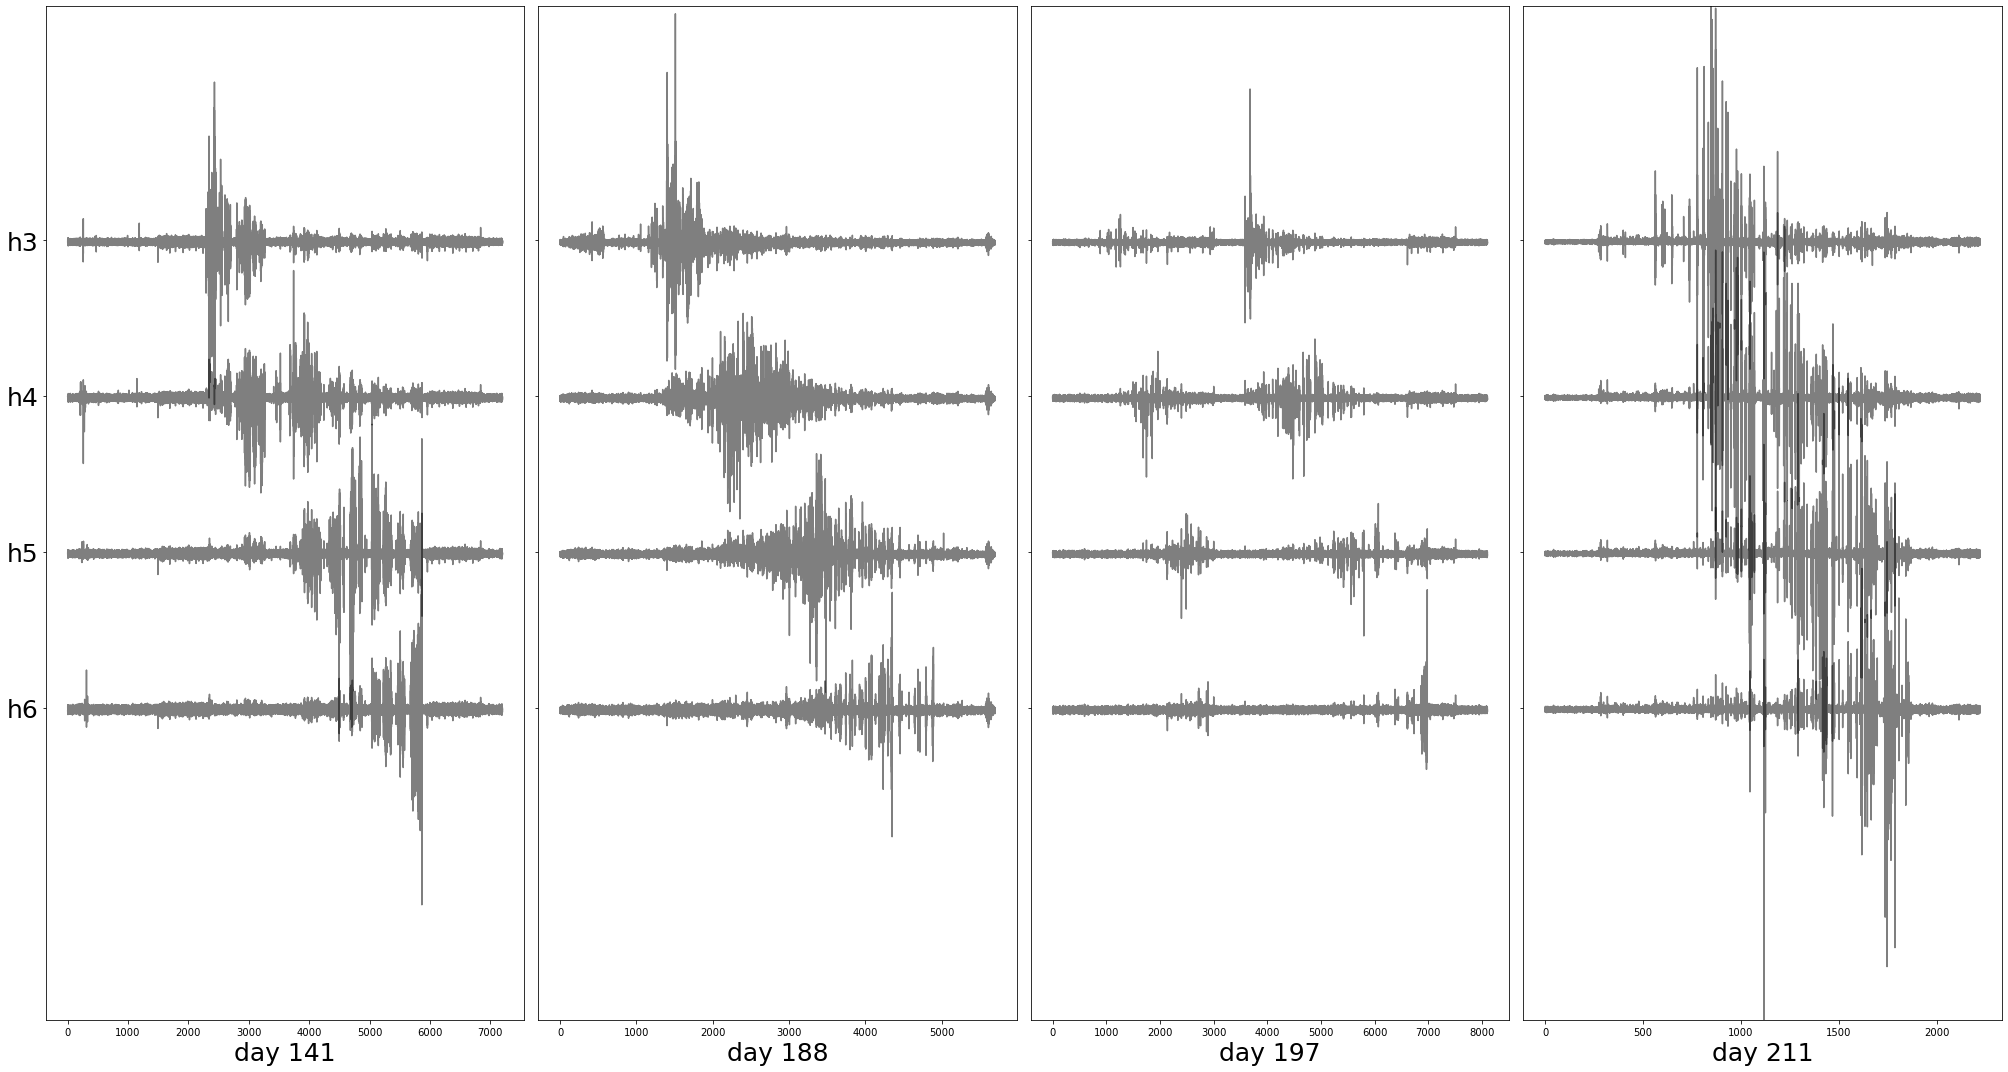

In [7]:
fig, ax = plt.subplots(1, 4, figsize=(7*4, 15), sharey=True)

def plot_waveform(ax, stream, day):
    times = [tr.times() for tr in stream][2:]
    data = [tr.data for tr in stream][2:]
    n = 0
    for t, d in zip(times, data):
        ax.plot(t, d - n * 10, color='black', alpha=0.5)
        n+=1
        
    ax.set_xlabel('day ' + str(day), fontsize=25)

plot_waveform(ax=ax[0], stream=day141, day=141)
plot_waveform(ax=ax[1], stream=day188, day=188)
plot_waveform(ax=ax[2], stream=day197, day=197)
plot_waveform(ax=ax[3], stream=day211, day=211)

ax[0].set_ylim(-50, 15)
ax[0].set_yticks([0, -10, -20, -30])
ax[0].set_yticklabels(['h3', 'h4', 'h5', 'h6'], fontsize=25)

plt.tight_layout()

In [8]:
import matplotlib.dates as dates

def import_catalog(file):
    df = pd.read_csv(file)
    df.sort_values(by='first_arrival', inplace=True)
    df['arrival_datetime'] = df.arrival_time.apply(dates.num2date)
    return df

def plot_depths(df, cmap, day):
    fig, ax = plt.subplots(figsize=(15, 5))
    ax.scatter(df.arrival_datetime, df.depth, marker='.', linewidth=0, c=df.first_hydrophone, cmap=cmap)
    ax.set_ylabel('day '+str(day), fontsize=25)
    ax.set_ylim(400, 50)
    ax.text(s='N_events={}'.format(df.shape[0]), x=df.arrival_time[50], y=375, fontsize=25)
    return fig, ax

def plot_radius(df, cmap, day):
    x = df.first_arrival.values
    y = np.abs(df.radius.values)
    c = df.depth.values
    
    fig, ax = plt.subplots(figsize=(15, 5))
    cbar = ax.scatter(x, y, marker='.', c=c, vmin=150, vmax=400, cmap=cmap)
    ax.set_xticks([])
    ax.set_ylim(-10, 60)
    fig.colorbar(cbar, label='depth (m)')
    ax.set_xlabel('time ---->', fontsize=15)
    ax.set_ylabel('radius (m)', fontsize=15)
    return fig, ax

In [9]:
df141 = import_catalog(file='precision.csv')
df188 = import_catalog(file='188precision.csv')
df197 = import_catalog(file='197precision.csv')
df211 = import_catalog(file='211precision.csv')

(<Figure size 1080x360 with 1 Axes>, <AxesSubplot:ylabel='day 211'>)

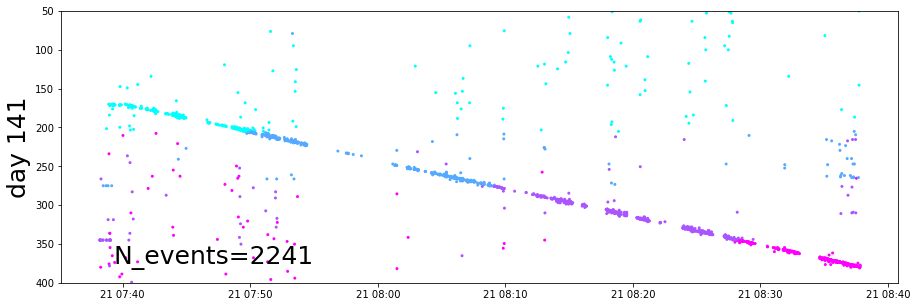

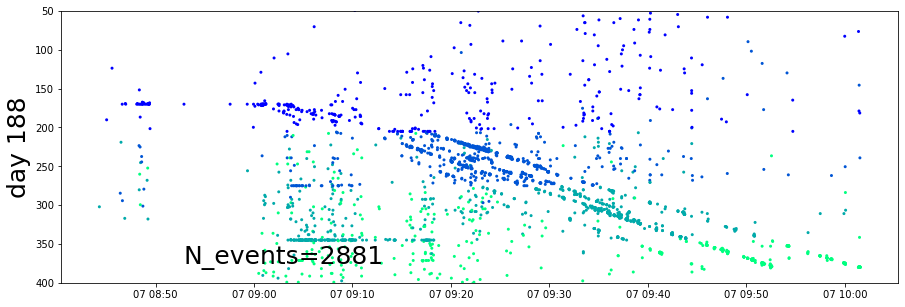

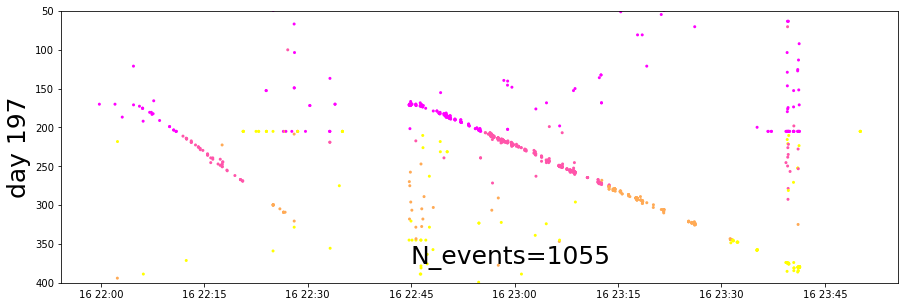

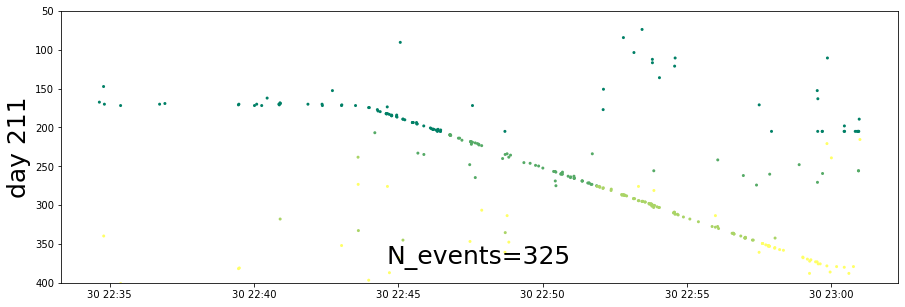

In [10]:
plot_depths(df=df141, cmap='cool', day=141)
plot_depths(df=df188, cmap='winter', day=188)
plot_depths(df=df197, cmap='spring', day=197)
plot_depths(df=df211, cmap='summer', day=211)

In [11]:
def remove_data_using_linear_model(X, y, removal_factor):
    
    model = LinearRegression().fit(X, y)
    predictions = model.predict(X)
    
    removal_index = np.hstack(
        (np.where(y > predictions + removal_factor*np.std(predictions))
        ,np.where(y < predictions - removal_factor*np.std(predictions)))
    )
    X_new = np.delete(X, removal_index)
    y_new = np.delete(y, removal_index)
    
    return X_new, y_new, model

def convert_matplotlib_numtimes_to_seconds_from_start(times):
    start = dates.num2date(times.min())
    end = dates.num2date(times.max())
    total_seconds = (end - start).total_seconds()

    seconds = np.array([(end - dates.num2date(t[0])).total_seconds() for t in times])
    return total_seconds - seconds

iteration: 0 | R2 score: 0.094327 +/- 5 * 31.076143350693656 | removed N= 163 | velocity (m/s): [0.02765019]
iteration: 1 | R2 score: 0.70317 +/- 5 * 55.66865348580648 | removed N= 0 | velocity (m/s): [0.04999229]
iteration: 2 | R2 score: 0.70317 +/- 5 * 55.66865348580648 | removed N= 0 | velocity (m/s): [0.04999229]
iteration: 3 | R2 score: 0.70317 +/- 4.0 * 55.66865348580648 | removed N= 0 | velocity (m/s): [0.04999229]
iteration: 4 | R2 score: 0.70317 +/- 3.0 * 55.66865348580648 | removed N= 11 | velocity (m/s): [0.04999229]
iteration: 5 | R2 score: 0.737009 +/- 2.0 * 56.70987494446255 | removed N= 71 | velocity (m/s): [0.0510321]
iteration: 6 | R2 score: 0.909694 +/- 2.0 * 62.40671432471288 | removed N= 0 | velocity (m/s): [0.05707571]


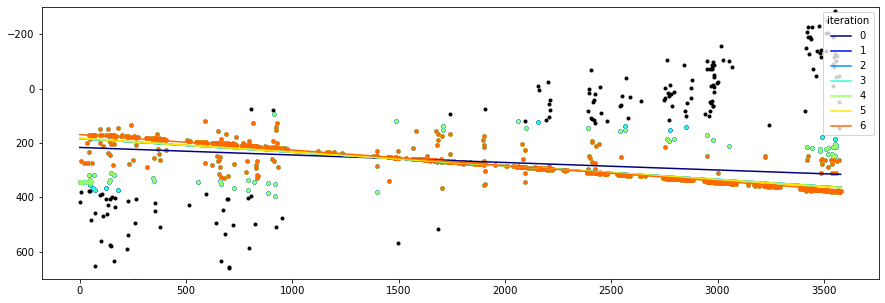

In [18]:
y = df141.depth.values
X = (df141.arrival_time).values.reshape(-1, 1)
X = convert_matplotlib_numtimes_to_seconds_from_start(X)
X = np.vstack(X)

fig, ax = plt.subplots(figsize=(15, 5))
ax.set_ylim(700, -300)

ax.scatter(X, y, marker='.', color='black')

xnew = X
ynew = y
iteration = 0
removal_factor = 5
while True:
    xold = xnew.reshape(-1, 1)
    yold = ynew
    if 'r2' not in locals():
        r2 = -9999
        r2_old = r2
    else:
        r2_old = r2
    xnew, ynew, mod = remove_data_using_linear_model(X=xold, y=yold, removal_factor=removal_factor)
    pred = mod.predict(xold)
    r2 = r2_score(yold, pred)
    print('iteration:', iteration , '|'
          , 'R2 score:', np.round(r2, 6), '+/-', removal_factor, '*', np.std(pred), '|'
          , 'removed N=', yold.shape[0] - ynew.shape[0], '|'
          , 'velocity (m/s):', mod.coef_
         )
    ########
    # plotting nonsense
    color = plt.cm.jet(iteration/7.5)
    ax.scatter(xnew, ynew, marker='.', color=color)
    xline = np.linspace(X.min(), X.max(), 1000)
    yline = mod.predict(xline.reshape(-1, 1))
    ax.plot(xline, yline, color=color)
    #
    ########
    
    iteration += 1
    if r2 > 0.8:
        break
    # elif r2_old == r2:
    elif np.isclose(r2_old, r2, rtol=1e-6):
        removal_factor = removal_factor - 1.0
    elif iteration == 1000:
        break
    else:
        pass
    
# ax.plot(xline, yline, color='red')
ax.legend(np.arange(iteration), title='iteration')

In [20]:
def do(df):

    y = df.depth.values
    X = (df.arrival_time).values.reshape(-1, 1)
    X = convert_matplotlib_numtimes_to_seconds_from_start(X)
    X = np.vstack(X)

    fig, ax = plt.subplots(figsize=(15, 5))
    ax.set_ylim(700, -300)

    ax.scatter(X, y, marker='.', color='black')

    xnew = X
    ynew = y
    iteration = 0
    removal_factor = 5
    while True:
        xold = xnew.reshape(-1, 1)
        yold = ynew
        if 'r2' not in locals():
            r2 = -9999
            r2_old = r2
        else:
            r2_old = r2
        xnew, ynew, mod = remove_data_using_linear_model(X=xold, y=yold, removal_factor=removal_factor)
        pred = mod.predict(xold)
        r2 = r2_score(yold, pred)
        print('iteration:', iteration , '|'
              , 'R2 score:', np.round(r2, 6), '+/-', removal_factor, '*', np.std(pred), '|'
              , 'removed N=', yold.shape[0] - ynew.shape[0], '|'
              , 'velocity (m/s):', mod.coef_
             )
        ########
        # plotting nonsense
        color = plt.cm.jet(iteration/7.5)
        ax.scatter(xnew, ynew, marker='.', color=color)
        xline = np.linspace(X.min(), X.max(), 1000)
        yline = mod.predict(xline.reshape(-1, 1))
        ax.plot(xline, yline, color=color)
        #
        ########

        iteration += 1
        if r2 > 0.8:
            break
        # elif r2_old == r2:
        elif np.isclose(r2_old, r2, rtol=1e-6):
            removal_factor = removal_factor - 1.0
        elif iteration == 1000:
            break
        else:
            pass

    # ax.plot(xline, yline, color='red')
    ax.legend(np.arange(iteration), title='iteration')

iteration: 0 | R2 score: 0.094327 +/- 5 * 31.076143350693656 | removed N= 163 | velocity (m/s): [0.02765019]
iteration: 1 | R2 score: 0.70317 +/- 5 * 55.66865348580648 | removed N= 0 | velocity (m/s): [0.04999229]
iteration: 2 | R2 score: 0.70317 +/- 5 * 55.66865348580648 | removed N= 0 | velocity (m/s): [0.04999229]
iteration: 3 | R2 score: 0.70317 +/- 4.0 * 55.66865348580648 | removed N= 0 | velocity (m/s): [0.04999229]
iteration: 4 | R2 score: 0.70317 +/- 3.0 * 55.66865348580648 | removed N= 11 | velocity (m/s): [0.04999229]
iteration: 5 | R2 score: 0.737009 +/- 2.0 * 56.70987494446255 | removed N= 71 | velocity (m/s): [0.0510321]
iteration: 6 | R2 score: 0.909694 +/- 2.0 * 62.40671432471288 | removed N= 0 | velocity (m/s): [0.05707571]


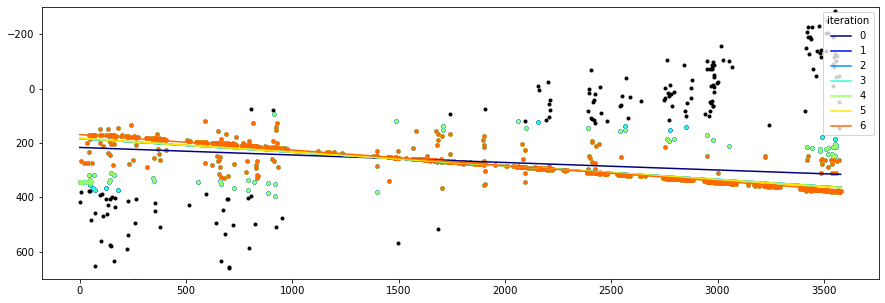

In [21]:
do(df=df141)

iteration: 0 | R2 score: 0.047162 +/- 5 * 16.154346100980494 | removed N= 529 | velocity (m/s): [0.01761904]
iteration: 1 | R2 score: 0.559338 +/- 5 * 40.19924453616837 | removed N= 0 | velocity (m/s): [0.04481178]
iteration: 2 | R2 score: 0.559338 +/- 5 * 40.19924453616837 | removed N= 0 | velocity (m/s): [0.04481178]
iteration: 3 | R2 score: 0.559338 +/- 4.0 * 40.19924453616837 | removed N= 0 | velocity (m/s): [0.04481178]
iteration: 4 | R2 score: 0.559338 +/- 3.0 * 40.19924453616837 | removed N= 5 | velocity (m/s): [0.04481178]
iteration: 5 | R2 score: 0.574171 +/- 2.0 * 40.76608944563998 | removed N= 78 | velocity (m/s): [0.04577908]
iteration: 6 | R2 score: 0.701248 +/- 2.0 * 45.35022827402629 | removed N= 4 | velocity (m/s): [0.05231015]
iteration: 7 | R2 score: 0.707344 +/- 2.0 * 45.58434333946467 | removed N= 0 | velocity (m/s): [0.05280669]
iteration: 8 | R2 score: 0.707344 +/- 2.0 * 45.58434333946467 | removed N= 0 | velocity (m/s): [0.05280669]
iteration: 9 | R2 score: 0.707

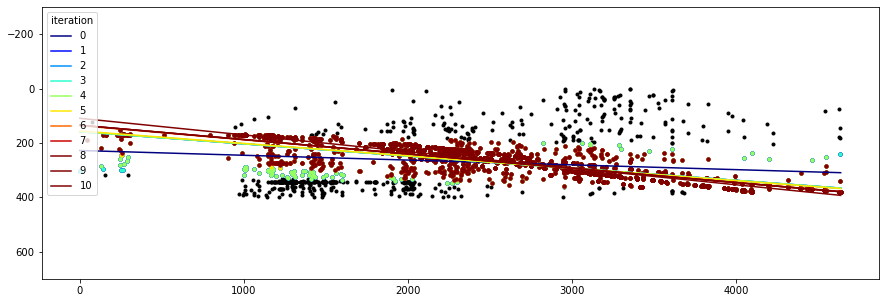

In [26]:
do(df=df188[df188.depth.between(0, 400)])

iteration: 0 | R2 score: 0.132151 +/- 5 * 23.395451504280427 | removed N= 43 | velocity (m/s): [0.02254481]
iteration: 1 | R2 score: 0.420505 +/- 5 * 36.14494096692799 | removed N= 0 | velocity (m/s): [0.03581487]
iteration: 2 | R2 score: 0.420505 +/- 5 * 36.14494096692799 | removed N= 0 | velocity (m/s): [0.03581487]
iteration: 3 | R2 score: 0.420505 +/- 4.0 * 36.14494096692799 | removed N= 1 | velocity (m/s): [0.03581487]
iteration: 4 | R2 score: 0.427909 +/- 3.0 * 36.44442457955488 | removed N= 32 | velocity (m/s): [0.03617945]
iteration: 5 | R2 score: 0.631254 +/- 3.0 * 44.00460461433327 | removed N= 0 | velocity (m/s): [0.04605404]
iteration: 6 | R2 score: 0.631254 +/- 3.0 * 44.00460461433327 | removed N= 0 | velocity (m/s): [0.04605404]
iteration: 7 | R2 score: 0.631254 +/- 2.0 * 44.00460461433327 | removed N= 41 | velocity (m/s): [0.04605404]
iteration: 8 | R2 score: 0.895323 +/- 1.0 * 52.44614855201634 | removed N= 25 | velocity (m/s): [0.05797522]


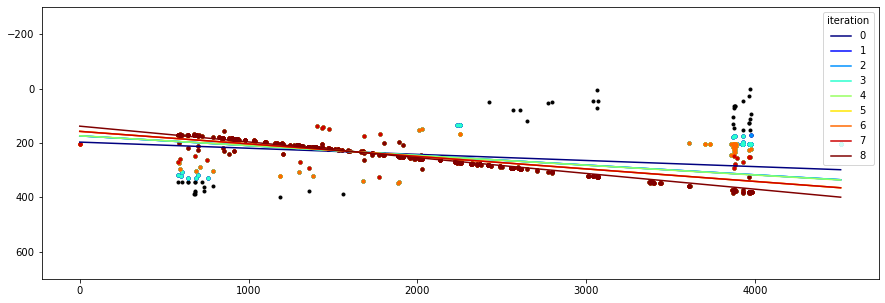

In [40]:
# remove the first event which is small
df = df197[155:]
do(df=df[df.depth.between(0, 400)])

iteration: 0 | R2 score: 0.161908 +/- 5 * 28.766727903013873 | removed N= 14 | velocity (m/s): [0.09440124]
iteration: 1 | R2 score: 0.357809 +/- 5 * 36.875277346768286 | removed N= 0 | velocity (m/s): [0.1206991]
iteration: 2 | R2 score: 0.357809 +/- 5 * 36.875277346768286 | removed N= 0 | velocity (m/s): [0.1206991]
iteration: 3 | R2 score: 0.357809 +/- 4.0 * 36.875277346768286 | removed N= 1 | velocity (m/s): [0.1206991]
iteration: 4 | R2 score: 0.376758 +/- 3.0 * 37.69918635328954 | removed N= 20 | velocity (m/s): [0.12364848]
iteration: 5 | R2 score: 0.736896 +/- 3.0 * 50.40586389583022 | removed N= 0 | velocity (m/s): [0.17405459]
iteration: 6 | R2 score: 0.736896 +/- 3.0 * 50.40586389583022 | removed N= 0 | velocity (m/s): [0.17405459]
iteration: 7 | R2 score: 0.736896 +/- 2.0 * 50.40586389583022 | removed N= 6 | velocity (m/s): [0.17405459]
iteration: 8 | R2 score: 0.850876 +/- 1.0 * 54.39087725852854 | removed N= 12 | velocity (m/s): [0.1916753]


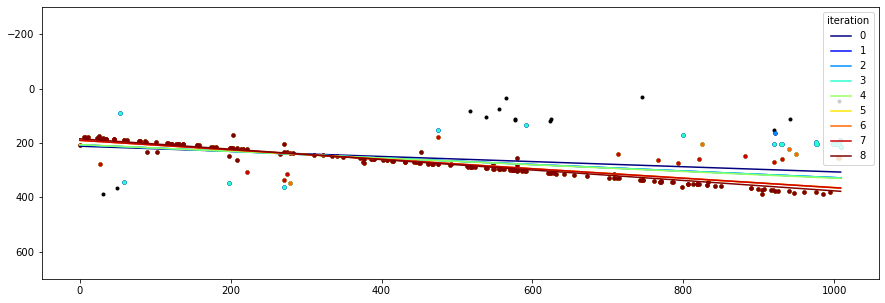

In [47]:
# remove first few events which make fitline nonlinear
df = df211[40:]
do(df=df[df.depth.between(0, 400)])

In [ ]:
plot_radius(df=df141, cmap='cool', day=141)
plot_radius(df=df188, cmap='winter', day=188)
plot_radius(df=df197, cmap='spring', day=197)
plot_radius(df=df211, cmap='summer', day=211)